# Chapter 6. Decision Trees

In [126]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

np.random.seed(0)

plt.style.use('seaborn-whitegrid')

In [127]:
%matplotlib inline

In [128]:
%load_ext ipycache

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


Decision trees can perform both classification and regression.
They can also perform multioutput tasks.

## Training and visualizing a decision tree

As an example, the following code trains a decision tree on the `iris` data set.

In [129]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

The tree can be saved and displayed as a graph.

In [130]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file='assets/ch06/iris_tree.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [131]:
%%bash
dot -Tpng assets/ch06/iris_tree.dot -o assets/ch06/iris_tree.png

![](assets/ch06/iris_tree.png)

## Making predictions

In the graph above, the top box (depth 0) is the root and the colored boxes are the leaves.
In each white box, the rule at the top is the decision boundary: if it is satisfied, the next step is to the box below and to the left (True).
The *samples* attribute of each node is the number of training samples that reached it.
The *value* attribute indicates how many of each class reached the node.
The *gini* attribute indicates the "purity" of the node, how many of the samples are of the correct class; a value of 0 is perfect ("pure").
The equation is below.

$$
G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2
$$

Here, $p_{i,k}$ is the ratio of class $k$ instances among the data instances in the $i^\text{th}$ node.

The CART algorithm employed by Scikit-Learn only produces binary nodes.
There are other algorithms, however, capable of making multiple decisions.

A nice benefit of using decision trees is that they are quite transparent, as shown by the ability to produce a graph of the decision process.
Further, it is easy to obtain feature importance values.

In [132]:
tree_clf.feature_importances_

array([0., 1.])

The plot below shows the decision boundaries of the decision tree model.

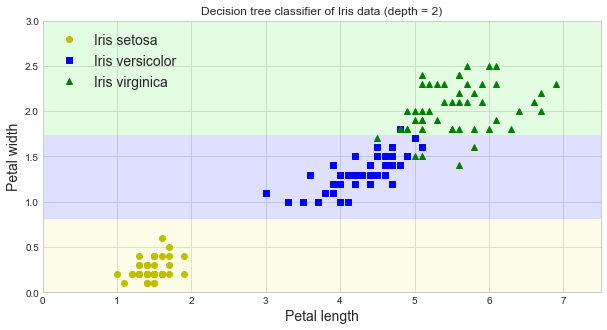

In [133]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3]):
    # Create a mesh to predict over.
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    # Plot the contour of the predictions.
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    # Plot the iris data points.
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
    
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    plt.legend(loc="upper left", fontsize=14)

plt.figure(figsize=(10, 5))
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision tree classifier of Iris data (depth = 2)")
plt.show()

The next example sets the maximum depth of 3.
This lets the classifier add another layer, making it even more accurate.

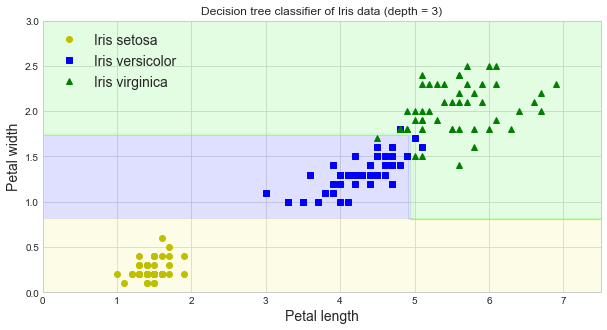

In [134]:
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X, y)

export_graphviz(
    tree_clf,
    out_file='assets/ch06/iris_tree_d3.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

plt.figure(figsize=(10, 5))
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision tree classifier of Iris data (depth = 3)")
plt.show()

In [135]:
tree_clf.feature_importances_

array([0.05393633, 0.94606367])

In [136]:
%%bash
dot -Tpng assets/ch06/iris_tree_d3.dot -o assets/ch06/iris_tree_d3.png

![](assets/ch06/iris_tree_d3.png)

The following example, where I allow for a maximum depth of 10, shows how decision trees can very quickly overfit the training data.

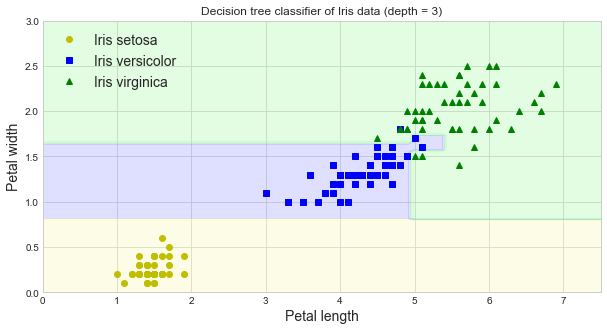

In [137]:
tree_clf = DecisionTreeClassifier(max_depth=10)
tree_clf.fit(X, y)

export_graphviz(
    tree_clf,
    out_file='assets/ch06/iris_tree_d10.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

plt.figure(figsize=(10, 5))
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision tree classifier of Iris data (depth = 3)")
plt.show()

In [138]:
%%bash
dot -Tpng assets/ch06/iris_tree_d10.dot -o assets/ch06/iris_tree_d10.png

![](assets/ch06/iris_tree_d10.png)

## Estimating class probabilities

A decision tree can be used to estimate the probability that an instance belongs to a class $k$.
For a given input, this probability is the ratio of $k$ to not-$k$ of the training data in the final leaf it reaches.

Below, I show the prediction from the tree with a depth of 3 for two inputs.
Both result in a prediction of *Virginica*, though they assign different probabilities.
The first example input ends up on the third leaf on the bottom row of the diagram shown previously above, while the second example input ends up on the last leaf.

In [139]:
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X, y)

def make_prediction(tree_mdl, x, return_results=False):
    """
    Print-out (and return) the prediction and probabilities for each class
    for a decision tree `tree_mdl` for input `x`.
    """
    predicted_class = iris.target_names[tree_mdl.predict(x)[0]]
    data = {
        'Plant': iris.target_names.reshape(3), 
        'Prob.': tree_mdl.predict_proba(x).reshape(3)
    }
    df = pd.DataFrame(data, columns=['Plant', 'Prob.'])
    
    print(f'predicted plant: {predicted_class}')
    print('probabilities:')
    print(df)
    
    if return_results:
        return predicted_class, df

In [140]:
make_prediction(tree_clf, [[3, 2]])

predicted plant: virginica
probabilities:
        Plant     Prob.
0      setosa  0.000000
1  versicolor  0.333333
2   virginica  0.666667


In [141]:
make_prediction(tree_clf, [[5, 2]])

predicted plant: virginica
probabilities:
        Plant  Prob.
0      setosa    0.0
1  versicolor    0.0
2   virginica    1.0


## The CART training algorithm

The Classification And Regression Tree (CART) algorithm is a greedy algorithm for fitting ("growing") a decision tree.
It begins by splitting the data into two subsets using a single feature $k$ and a threshold $t_k$ that minimizes the following cost function.
This cost function searches for a $k$ and $t_k$ that produces the purest subsets, seighted by their size.

$$
J(k, t_k) = \frac{m_\text{left}}{m}G_\text{left} + \frac{m_\text{right}}{m}G_\text{right}\\
\text{where} 
\begin{cases}
    G_\text{left/right} \text{measures the impurity of the left/right subset} \\
    m_\text{left/right} \text{is the number of training instances in the left/right subset} \\
\end{cases}
$$

This continues recursively until a stopping condition is met.
Algorithmically, this is when greater impurity cannot be obtained.
Alternatively, there are hyperparameters that can decide the stopping condition to prevent overfitting.
These include the maximum depth of the tree and others described below (`min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_leaf_nodes`, and `max_features` are common hyperparameters to tune in Scikit-Learn).

## Gini impurity or entropy

The default measure of the quality of a split is `'gini'` for using the Gini impurity.
The other supported option is `'entropy'` to use the Shannon's information criterion (the equation is shown below).
Generally, there is little difference between the results of using either.
As Gini impurity is generally quicker to measure, it is a good default.
However, when there is a substantial difference, the entropy measure tends to produce more balanced trees.

$$
H_i = - \sum_{\substack{k=1 \\ p_{i,k} \neq 0}}^{n} p_{i,k} \: \text{log}_2 (p_{i,k})
$$

The following code creates decision trees using both `criterion='gini'` and `criterion='entropy'` for the `iris` data set.
There is no appreciable differences between the results.

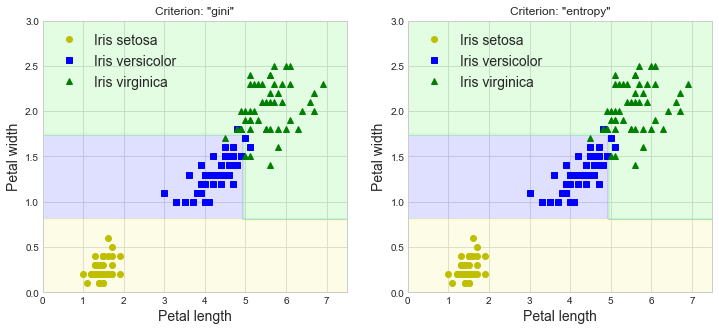

In [142]:
np.random.seed(0)

fig = plt.figure(figsize=(12, 5))

for i, c in enumerate(['gini', 'entropy']):
    tree_clf = DecisionTreeClassifier(criterion=c, max_depth=3)
    tree_clf.fit(X, y)

    plt.subplot(1, 2, i+1)
    plot_decision_boundary(tree_clf, X, y)
    plt.title(f'Criterion: \"{c}\"')

plt.show()

## Regularization hyperparameters

Decision trees, as they are nonparametric, can easily adapt to the training data, often overfitting.
Here are some of the common parameters:

- `max_depth`: The maximum depth of the tree.
- `min_samples_split`: The minimum number of instances a node must have in order to split further.
- `min_samples_leaf`: The minimum number of samples a leaf node must have.
- `min_weight_fraction_leaf`: The minimum fraction of the samples that a leaf must have.
- `max_leaf_nodes`: The maximum number of leaves.
- `max_features`: The maximum number of features used for splitting at each node.

Some algorithms use "pruning" to remove unnecessary nodes.
They essentially grow the tree to completion and then remove nodes that fail to improve the purity to a statistically significant level.

### Example

I use the example moon data to play around with the Scikit-Learn Decision Tree Classifier.
Inspiration for the general problem is from Exercise 7 of this chapter.

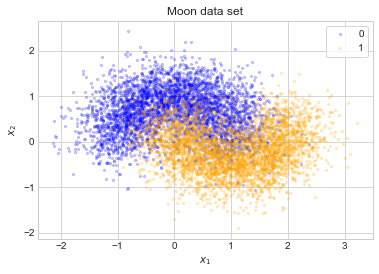

In [143]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Make moon data.
X, y = make_moons(n_samples=10000, noise=0.4, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Plot moon data.
def plot_moon_data(x_vals, y_vals):
    plt.scatter(x_vals[:, 0][y_vals == 0], x_vals[:, 1][y_vals == 0], 
                color='blue', label='0', alpha=0.2, s=5)
    plt.scatter(x_vals[:, 0][y_vals == 1], x_vals[:, 1][y_vals == 1], 
                color='orange', label='1', alpha=0.2, s=5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(loc='best', frameon=True)

plot_moon_data(X_train, y_train)
plt.title("Moon data set")
plt.show()

In [144]:
moon_axes = [-2.5, 4.0, -2.0, 2.5]

def plot_decision_boundary(clf, x_vals, y_vals, axes, include_data=True):
    """Plot the decision boundaries for the moon data."""
    
    # Create a mesh to predict over.
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    # Plot the contour of the predictions.
    custom_cmap = ListedColormap(['#bfeeff', '#ffecb8'])
    plt.contourf(x1, x2, y_pred, alpha=0.6, cmap=custom_cmap)

    # Plot the iris data points.
    if include_data:
        plot_moon_data(x_vals, y_vals)

The following tree uses only the default decision tree.
It massively overfits, evident by strange shapes and thin strips of one color piercing into the other.

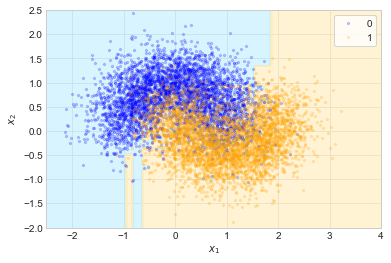

In [145]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
plot_decision_boundary(tree_clf, X_train, y_train, moon_axes)

A grid search is performed to find the optimal hyperparamters.
I began with a very coarse search, then implemented a finer and longer-running search based off of those results.

In [146]:
%%cache -d caches ch06_coarse_grid_search.pkl tree_clf, clf, coarse_grid

from sklearn.model_selection import GridSearchCV

coarse_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.linspace(2, 100, 10, dtype=int),
    'max_features': [1, 2],
    'max_leaf_nodes': np.linspace(10, 100, 6, dtype=int),
    'min_impurity_decrease': [0.005, 0.01, 0.1],
    'min_samples_leaf': np.linspace(25, 200, 4, dtype=int),
    'min_samples_split': np.linspace(25, 200, 4, dtype=int),
}

tree_clf = DecisionTreeClassifier()

clf = GridSearchCV(estimator=tree_clf,
                  param_grid=coarse_grid,
                  cv=5)
clf.fit(X_train, y_train)

[Skipped the cell's code and loaded variables clf, coarse_grid, tree_clf from file '/Users/admin/Developer/Python/100DaysOfPython/HandsOnMachineLearningWithScikitLearnAndTensorFlow/caches/ch06_coarse_grid_search.pkl'.]


In [147]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 2,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.005,
 'min_samples_leaf': 25,
 'min_samples_split': 25}

In [148]:
clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=2, max_leaf_nodes=10,
                       min_impurity_decrease=0.005, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [149]:
clf.best_score_

0.8553750000000001

In [150]:
%%cache -d caches ch06_fine_grid_search.pkl tree_clf, clf, fine_grid

# A finer-grained parameter grid.
fine_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(4, 26, 2, dtype=int),
    'max_features': [1],
    'max_leaf_nodes': np.arange(4, 31, 4, dtype=int),
    'min_impurity_decrease': [0.0, 0.001, 0.005, 0.01],
    'min_samples_leaf': np.arange(10, 41, 5, dtype=int),
    'min_samples_split': np.arange(10, 41, 5, dtype=int),
}

tree_clf = DecisionTreeClassifier()

clf = GridSearchCV(estimator=tree_clf,
                  param_grid=fine_grid,
                  cv=5)
clf.fit(X_train, y_train)

[Skipped the cell's code and loaded variables clf, fine_grid, tree_clf from file '/Users/admin/Developer/Python/100DaysOfPython/HandsOnMachineLearningWithScikitLearnAndTensorFlow/caches/ch06_fine_grid_search.pkl'.]


In [151]:
best_moon_params = clf.best_params_  # Save for Exercise 8 at the end.
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 1,
 'max_leaf_nodes': 28,
 'min_impurity_decrease': 0.001,
 'min_samples_leaf': 20,
 'min_samples_split': 35}

In [152]:
clf.best_score_

0.8628750000000001

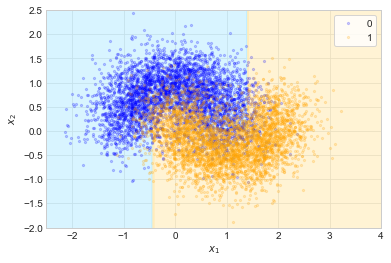

In [153]:
best_tree_clf = clf.best_estimator_
plot_decision_boundary(best_tree_clf, X_train, y_train, moon_axes)
plt.show()

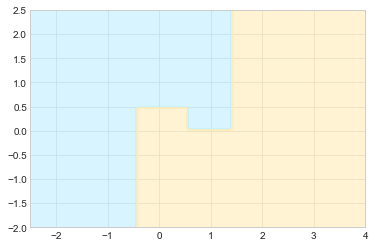

In [154]:
plot_decision_boundary(best_tree_clf, 
                       X_train, 
                       y_train, 
                       moon_axes,
                       include_data=False)
plt.show()

In [155]:
# Train error
y_train_predict = best_tree_clf.predict(X_train)
sum(y_train_predict == y_train) / len(y_train)

0.863125

In [156]:
# Test error
y_test_predict = best_tree_clf.predict(X_test)
sum(y_test_predict == y_test) / len(y_test)

0.8655

## Regression

A decision tree can also be used for regression.
The main difference is that instead of each leaf having a class, they instead have a value.
The predicted value is the average of the values at the leaf.

The CART algorithm works similarly to that for classification, just this time it is minimizing the MSE to decide where to split the data.

As an example, the following builds a decision tree regressor for a noisy quadratic data set.

In [157]:
from sklearn.tree import DecisionTreeRegressor

# Mock data of a quadratic formula: y = 2x^2 - 3x + 5 + N()
n = 300
X = np.linspace(-4, 4, n) + np.random.randn(n)
y = 2.0 * X**2 + (-3.0) * X + 5 + (np.random.randn(n) * 10.0)

# Fit decision tree regressor with max_depth=2.
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X.reshape(-1, 1), y)

# Export the graph of the tree.
export_graphviz(
    tree_reg,
    out_file='assets/ch06/tree_reg_quadratic.dot',
    feature_names='x',
    class_names='y',
    rounded=True,
    filled=True
)

In [158]:
%%bash
dot -Tsvg assets/ch06/tree_reg_quadratic.dot -o assets/ch06/tree_reg_quadratic.svg

![](assets/ch06/tree_reg_quadratic.svg)

Below, I have included a demonstration of the shape of the regressions with varying values for `max_depth` of the tree.
The models can overfit data very easily.

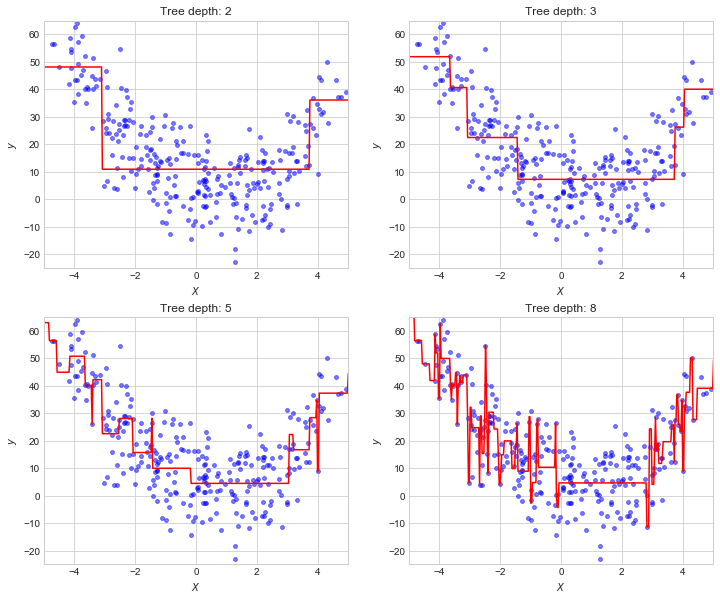

In [159]:
def plot_regression_tree(tree_mdl, X, y, axes):
    """Plot the predictions for a decision tree regressor model."""
    # Plot the data points.
    plt.scatter(X, y, color='blue', label='data', s=15, alpha=0.5)

    # Plot the predictions.
    X_new = np.linspace(axes[0]-2, axes[1]+2, 500)
    y_new = tree_mdl.predict(X_new.reshape(-1, 1))
    plt.plot(X_new, y_new, 'r-', label='regression tree')

    # Details
    plt.xlabel('$X$')
    plt.ylabel('$y$')
    plt.axis(axes)


# Plot 4 regressors with varying depth.
fig = plt.figure(figsize=(12, 10))
fig_axes = [-5, 5, -25, 65]

for i, d in enumerate([2, 3, 5, 8]):
    tree_mdl = DecisionTreeRegressor(max_depth=d)
    tree_mdl.fit(X.reshape(-1, 1), y)
    plt.subplot(2, 2, i+1)
    plot_regression_tree(tree_mdl, X, y, fig_axes)
    plt.title(f'Tree depth: {d}')

plt.show()

A grid search over the regularization parameters of the decision tree can help combat overfitting.

In [160]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

param_grid = {
    'max_depth': np.arange(2, 21, 1, dtype=int),
    'min_samples_split': np.arange(2, 20, 1, dtype=int),
}

tree_reg = DecisionTreeRegressor()

clf = GridSearchCV(estimator=tree_reg,
                  param_grid=param_grid,
                  cv=5)
clf.fit(X_train.reshape(-1, 1), y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                         

In [161]:
clf.best_params_

{'max_depth': 4, 'min_samples_split': 14}

In [162]:
clf.best_score_

0.6602906718789499

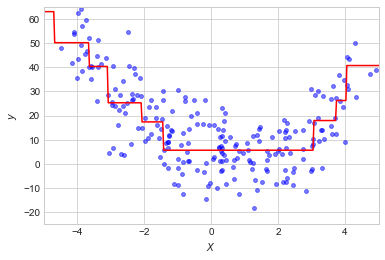

In [163]:
y_predicted = clf.best_estimator_.predict(X_train.reshape(-1, 1))
plot_regression_tree(clf.best_estimator_, X_train, y_train, fig_axes)

In [164]:
from sklearn.metrics import mean_squared_error

# Training MSE.
mean_squared_error(y_train, clf.best_estimator_.predict(X_train.reshape(-1, 1)))

91.61548953612372

In [165]:
# Testing MSE.
mean_squared_error(y_test, clf.best_estimator_.predict(X_test.reshape(-1, 1)))

118.30788384376102

## Instability

### Rotation

The first main limitation of decision trees is that they make cuts orthogonal to the features.
Therefore, they are very sensitive to the rotation of the training data.
This is demonstrated below.

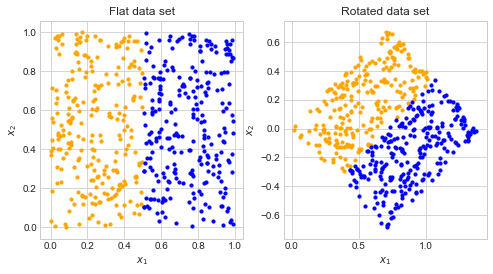

In [166]:
# Flat data
n = 500
x1 = np.random.rand(n)
x2 = np.random.rand(n)

# Rotated by 30 degrees
rot = np.pi * 45 / 180
x1_rot = x1 * np.cos(rot) + x2 * np.sin(rot)
x2_rot = x2 * np.cos(rot) - x1 * np.sin(rot)

y = np.array([0 if x < 0.5 else 1 for x in x1])

pal = ['orange', 'blue']

fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(x1[y == 0], x2[y == 0], color=pal[0], s=10)
plt.scatter(x1[y == 1], x2[y == 1], color=pal[1], s=10)
plt.title("Flat data set")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.subplot(1, 2, 2)
plt.scatter(x1_rot[y == 0], x2_rot[y == 0], color=pal[0], s=10)
plt.scatter(x1_rot[y == 1], x2_rot[y == 1], color=pal[1], s=10)
plt.title("Rotated data set")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.show()

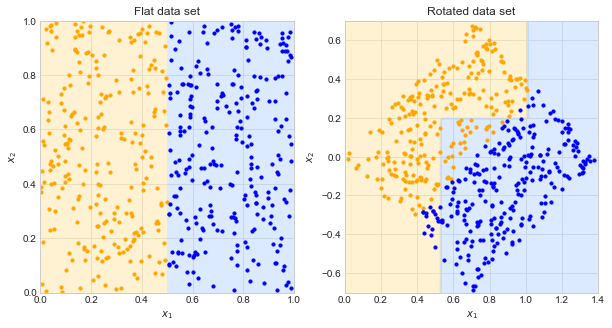

In [167]:
X = np.c_[x1, x2]
X_rot = np.c_[x1_rot, x2_rot]

# Fit decision tree regressor on flat data.
tree_reg_flat = DecisionTreeClassifier(max_depth=2)
tree_reg_flat.fit(X, y)

# Decision tree for the rotated data.
tree_reg_rot = DecisionTreeRegressor(max_depth=2)
tree_reg_rot.fit(X_rot, y)

fig = plt.figure(figsize=(10, 5))

def plot_2d_classification_tree(tree_mdl, X, y, axes):
    x1_new = np.linspace(axes[0], axes[1], 100)
    x2_new = np.linspace(axes[2], axes[3], 100)
    x1_new, x2_new = np.meshgrid(x1_new, x2_new)
    X_new = np.c_[x1_new.ravel(), x2_new.ravel()]
    y_pred = tree_mdl.predict(X_new).reshape(x1_new.shape)
    
    # Plot the contour of the predictions.
    custom_cmap = ListedColormap(['#ffe7a6', '#bad6ff'])
    plt.contourf(x1_new, x2_new, y_pred, alpha=0.5, cmap=custom_cmap)
    
    plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], color=pal[0], alpha=1, s=10)
    plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], color=pal[1], alpha=1, s=10)
    plt.axis(axes)


plt.subplot(1, 2, 1)
plot_2d_classification_tree(tree_reg_flat, X, y, [0, 1, 0, 1])
plt.title("Flat data set")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.subplot(1, 2, 2)
plot_2d_classification_tree(tree_reg_rot, X_rot, y, [0, 1.4, -0.7, 0.7])
plt.title("Rotated data set")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.show()

This can be fought using PCA.

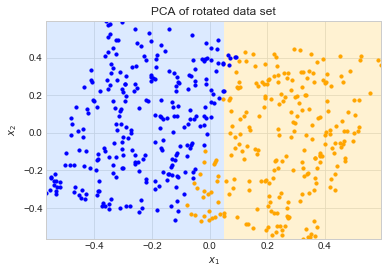

In [168]:
from sklearn.decomposition import PCA

# PCA on rotated data set.
pca = PCA(2)
pca.fit(X)
X_pca = pca.fit_transform(X_rot)


tree_reg_pca = DecisionTreeClassifier(max_depth=2)
tree_reg_pca.fit(X_pca, y)

pca_axes = [
    min(X_pca[:, 0]), max(X_pca[:, 0]),
    min(X_pca[:, 1]), max(X_pca[:, 1]),
]


plot_2d_classification_tree(tree_reg_pca, X_pca, y, pca_axes)
plt.title("PCA of rotated data set")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.show()

### Sensitive to variation

A decision tree model can be quite different based on the removal of individual or small subsets of training data.
Further, the Scikit-Learn implementation of the fitting algorithm is stochastic.
Thus, multiple models can be received from the same training data.
This is shown below where multiple models are run on different subsets of the `iris` data set.
The subsets are drawn by taking each row with 95% chance (a biased coin flip).

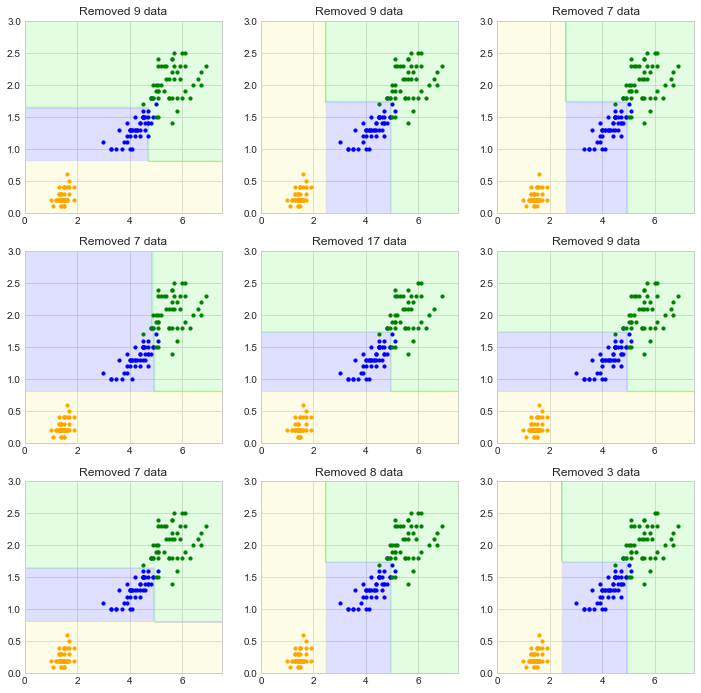

In [169]:
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3]):
    # Create a mesh to predict over.
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    # Plot the contour of the predictions.
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    # Plot the iris data points.
    plt.scatter(X[:, 0][y==0], X[:, 1][y==0], color='orange', s=10)
    plt.scatter(X[:, 0][y==1], X[:, 1][y==1], color='blue', s=10)
    plt.scatter(X[:, 0][y==2], X[:, 1][y==2], color='green', s=10)


iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

fig = plt.figure(figsize=(12, 12))
for i in range(1, 10):
    
    flips = np.random.binomial(n=1, p=0.95, size=X.shape[0])
    idx = [True if x == 1 else False for x in flips]
    
    X_subset = X[idx, :]
    y_subset = y[idx]
    
    tree_clf = DecisionTreeClassifier(max_depth=3)
    tree_clf.fit(X_subset, y_subset)
    
    plt.subplot(3, 3, i)
    plot_decision_boundary(tree_clf, X_subset, y_subset)
    plt.title(f'Removed {X.shape[0] - len(y_subset)} data')

plt.show()

### Exercise 7

(This was completed in an above example.)

### Exercise 8

Grow a forest by following these steps:

1. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly (use `ShuffleSplit`).
2. Train one decision tree on each subset using the best hyperparamters from Exercise 7. Evaluate these trees on the test set.
3. For each test set instance, generate predictions from each of the 1,000 trees, keeping only the most frequent prediction (using Scipy-Learn's `mode()`).
4. Evaluate these results on the test data. How does it compare to the original model?

In [170]:
from sklearn.model_selection import ShuffleSplit
from scipy.stats import mode

# Make moon data.
X, y = make_moons(n_samples=10000, noise=0.4, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Get 1000 splits of `X_train` into size 100.
rs = ShuffleSplit(n_splits=1000, test_size=100, random_state=0)
rs.get_n_splits(X_train)

# Train 1000 decision trees.
tree_clfs = []
for _, test_index in rs.split(X_train):
    tr = DecisionTreeClassifier(**best_moon_params)
    X_new = X_train[test_index, ]
    y_new = y_train[test_index]
    tr.fit(X_new, y_new)
    tree_clfs.append(tr)

    
def predict_on_tree_list(tree_list, new_X):
    """Find predictions for a list of trees."""
    predictions = []
    for tr in tree_list:
        predictions.append(tr.predict(new_X))
    
    df = pd.DataFrame(predictions).T
    consensus = df \
        .apply(mode, axis=1) \
        .apply(lambda x: int(x[0]))
    return consensus


y_train_predict = predict_on_tree_list(tree_clfs, X_train)
train_error = np.sum(y_train_predict == y_train) / len(y_train)

y_test_predict = predict_on_tree_list(tree_clfs, X_test)
test_error = np.sum(y_test_predict == y_test) / len(y_test)

# Results.
print(f'train error: {train_error}, test error: {test_error}')

train error: 0.814875, test error: 0.8195
